In [57]:
import torch
from torch import nn, Tensor

import fcnn, unet
from data.loaders import SteelLoader

import numpy as np
from os import path

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns

from tqdm.auto import tqdm

import metrics

# Specify test

In [41]:
data_source = "training_results/steel-unet_v1-lr-0.001/"
checkpoint = "epoch50state.torch"

dim_in = 3
dim_out =5

# Training Loss Curve

In [42]:
epoch_losses = []
with open(path.join(data_source, "train_losses.txt"), "r") as tloss:
    epoch_losses=tloss.readlines()
    epoch_losses = [float(l) for l in epoch_losses]

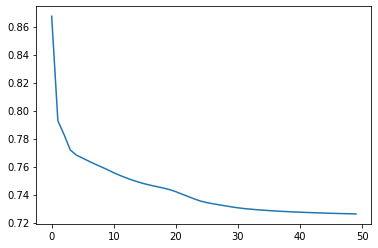

In [43]:
plt.figure()
plt.plot(epoch_losses)
plt.show()
plt.close()

# Get metrics on test set

In [44]:
network = unet.simple_unet_v1(3, 5)
network.load_state_dict(torch.load(path.join(data_source, checkpoint),
                                    map_location=torch.device("cpu")))
network.eval()

steel_train = SteelLoader(train = False)

In [45]:
# confusion_matrix[actual_class][predicted_class]
confusion_matrix = np.zeros((dim_out , dim_out))

# Confusion on a strict defect/no-defect basis (P(defect) is sum over probabilities
# for each defect class). Index as defect_confusion[actual][predicted], with 0 =
# defect exists and 1 = no defect.
defect_confusion = np.zeros((2,2))

steel_train.shuffle()
for x, y in tqdm(steel_train):
    # REMOVE THIS:
    x = x * 255
    y_pred: torch.Tensor = network(x).detach()

    # update the confusion matrix
    no_defect_class = y.shape[1] - 1 # no-defect channel is last 

    pred_labels = np.array(y_pred.argmax(dim = 1)).flatten()
    true_labels = np.array(y.argmax(dim = 1)).flatten()
    pred_no_defect = (np.array(y_pred)[:,-1] > 0.5).flatten()

    confusion_matrix += metrics.confusion_matrix(true_labels, pred_labels, y.shape[1])
    defect_confusion += metrics.confusion_matrix(true_labels == no_defect_class, pred_no_defect, 2)

  0%|          | 0/45 [00:00<?, ?it/s]

# Plot results

## IoU scores by class

In [46]:

ious = metrics.metric_iou(confusion_matrix)
print(ious)

[0.00221729 0.         0.25466272 0.00539019 0.93181024]


# Confusion Matrices

In [47]:
def plot_confusion_matrix(conf_mat):
    conf_mat = metrics.normalize_confusion(conf_mat)
    metrics.apply_names(conf_mat)
    plt.figure()
    sns.heatmap(conf_mat, vmin = 0, vmax = 1, annot = True, fmt = ".2f", cmap = "OrRd")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()
    plt.close()

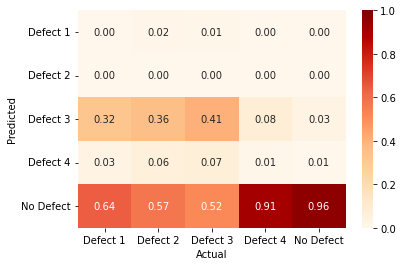

In [48]:
plot_confusion_matrix(confusion_matrix)

col_0           0            1
row_0                         
0      17243985.0   16301806.0
1      22146320.0  490304689.0


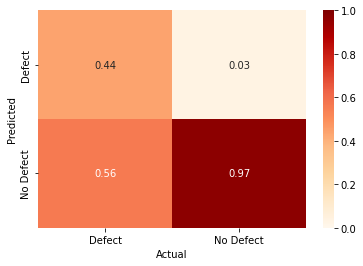

In [49]:
print(defect_confusion)
plot_confusion_matrix(defect_confusion)

In [62]:
img_ind = 1
img = np.array(x[img_ind])
target_labels = np.array(y[img_ind].detach())
predicted_labels = np.array(y_pred[img_ind].detach())

In [54]:
def plot_img(arr):
    if len(arr.shape) == 3 and arr.shape[0] > 1:
        arr = np.mean(np.array(arr)[:4], axis = 0)
    plt.figure()
    plt.imshow(arr, cmap="gray", vmax=1, vmin=0)
    plt.show()
    plt.close()

In [95]:
def compare_prediction(img: np.ndarray, ground_truth: np.ndarray, pred: np.ndarray, show_channels = None):
    img_sequence = [img / 255]
    nc = len(ground_truth)
    if show_channels is None:
        show_channels == range(nc)
    for c in show_channels:
        img_sequence.append(ground_truth[c])
        img_sequence.append(pred[c])
    
    for i in range(len(img_sequence)):
        if len(img_sequence[i].shape) == 3:
            img_sequence[i] = np.array(img_sequence[i]).transpose(1,2,0)

    plt.figure()
    aspect = img.shape[2] / img.shape[1]
    isns.ImageGrid(img_sequence, col_wrap=1, aspect=aspect, vmin = 0, vmax = 1)

    plt.show()
    plt.close()

TypeError: 'ImageGrid' object is not subscriptable

<Figure size 432x288 with 0 Axes>

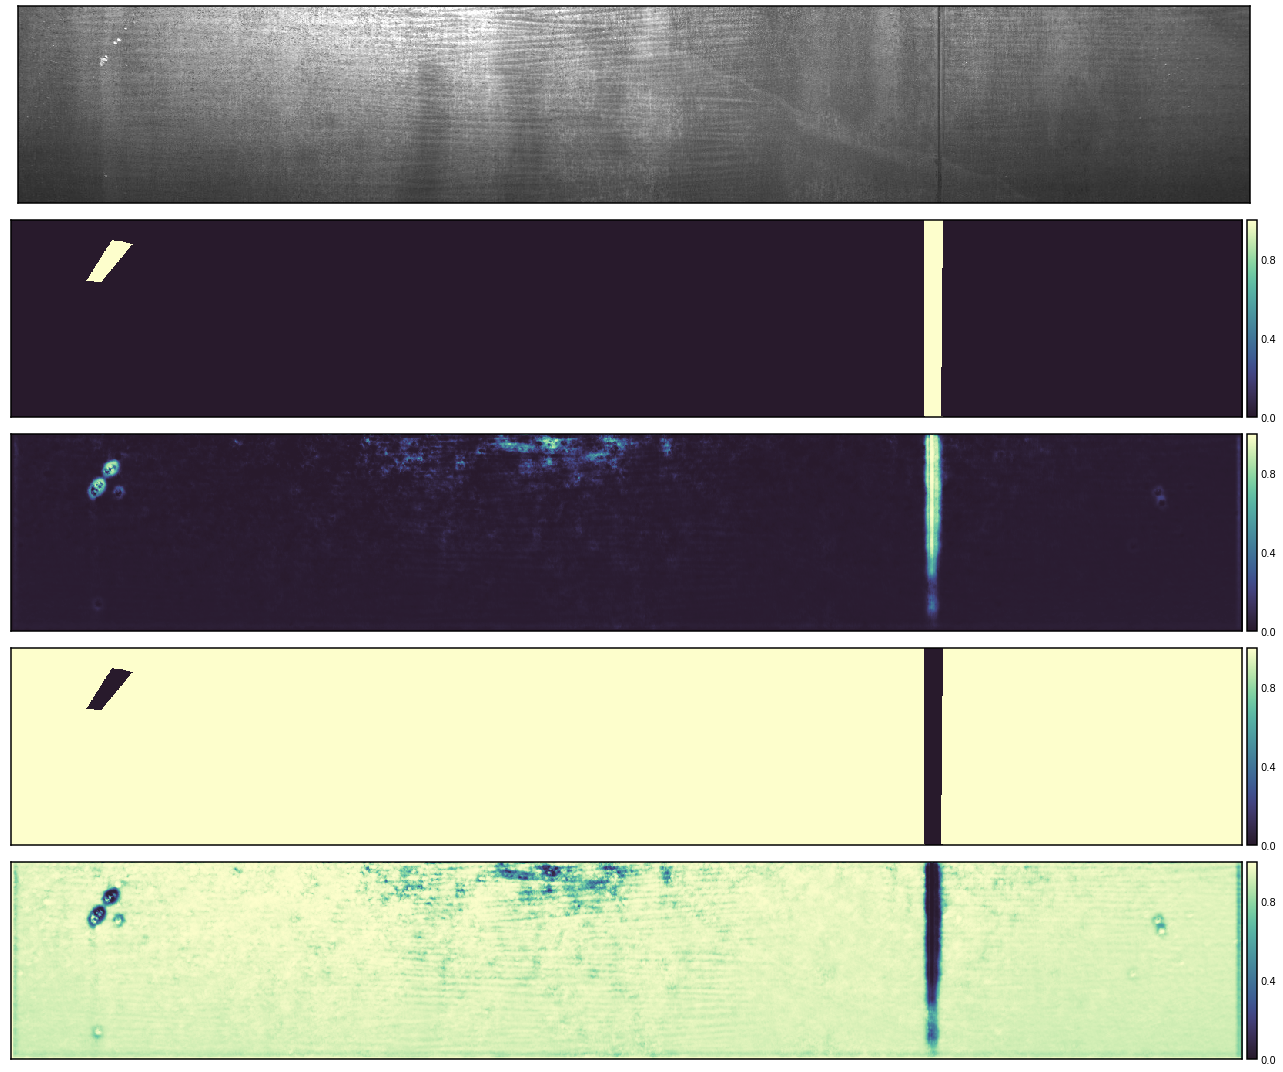

In [96]:
compare_prediction(img, target_labels, predicted_labels, show_channels=[2,4])

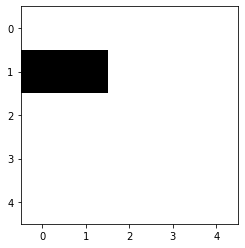

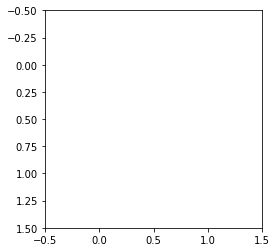

channel  0


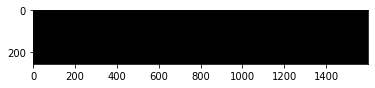

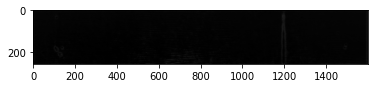

channel  1


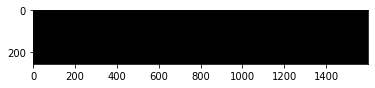

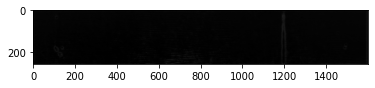

channel  2


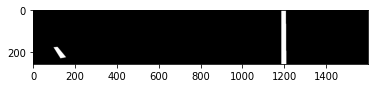

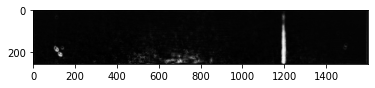

channel  3


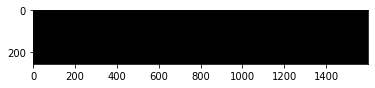

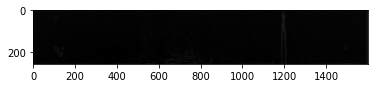

channel  4


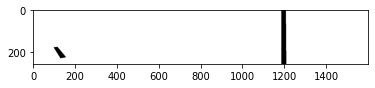

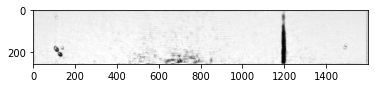

In [55]:
for channel in range(5):
    print("channel ", channel)
    plot_img(target_labels[channel])
    plot_img(predicted_labels[channel])

In [56]:
print(confusion_matrix)

col_0      0      1           2        3            4
row_0                                                
0        2.0   10.0    333256.0     23.0     462182.0
1        0.0    0.0     61907.0      3.0      93319.0
2      146.0  233.0  12888035.0   1509.0   14079721.0
3       14.0   38.0   2108979.0    203.0    3516211.0
4      290.0  374.0  16355966.0  17194.0  496077185.0
